# 04 - Time Series

This module was built by Ignacio Oguiza among others, see [this](https://forums.fast.ai/t/timeseries/55861/1) megathread for the discussion. The essential goal here is we can use arrays of any dimension instead of just 1 (such as tabular) or 3 (such as images). 

* Note, this notebook was heavily influenced from his tutorial notebook [here](https://github.com/timeseriesAI/timeseriesAI2/blob/master/tutorial_nbs/01_How_to_use_numpy_arrays_in_fastai.ipynb)

In [ ]:
pip install fastai

We'll need a few more libraries and the `timeseriesAI2` github:

In [ ]:
pip install pyunpack sktime -q
!git clone 'https://github.com/timeseriesAI/timeseriesAI2.git'
%cd timeseriesAI2

Now let's grab what we need:

In [ ]:
from fastai.tabular.all import *

In [ ]:
from timeseries.imports import *
from timeseries.utils import *
from timeseries.data import *
from timeseries.core import *
from timeseries.models import *

For our data we'll be utilizing the UCR repository which has 128 univariate and 30 multivariate datasets. In the framework we can quickly grab any dataset we want:

In [ ]:
name = 'StarLightCurves'

We can now grab our train and validation by calling `get_UCR_data`:

In [ ]:
X_train, y_train, X_valid, y_valid = get_UCR_data(name, verbose=True, on_disk=True)

Dataset: StarLightCurves
...data downloaded and decompressed
X_train: (1000, 1, 1024)
y_train: (1000,)
X_valid: (8236, 1, 1024)
y_valid: (8236,) 



Since data is already split between train and test in the UCR dataset, we are going to merge them and create some indices to split them in the same sets. To save on memory, he figured out a way to utilized the numpy arrays via your disk. We'll do so as follows:

In [ ]:
X = np.concatenate((X_train, X_valid))
y = np.concatenate((y_train, y_valid))

In [ ]:
np.save('./data/UCR/StarLightCurves/X.npy', X)
np.save('./data/UCR/StarLightCurves/y.npy', y)
del X, y

Now we can load them back in and make our splits:

In [ ]:
X = np.load('./data/UCR/StarLightCurves/X.npy', mmap_mode='r')
y = np.load('./data/UCR/StarLightCurves/y.npy', mmap_mode='r')

In [ ]:
splits = (L(np.arange(len(X_train)), use_list=True),
          L(np.arange(len(X_train), len(X)), use_list=True))

In [ ]:
splits

((#1000) [0,1,2,3,4,5,6,7,8,9...],
 (#8236) [1000,1001,1002,1003,1004,1005,1006,1007,1008,1009...])

Since we used memmap the data is being directly read from memory. Now to make and use your own data they need to be in a three dimentional array with a format of:

* Samples
* Variables
* Length (or timesteps)

To use this we have a special `TSTensor` built to handle such data:

In [ ]:
t = TSTensor(X)

In [ ]:
t

TSTensor(samples:9236, vars:1, len:1024)

So here we can see we had 60 samples with one variable and an overall time length of 570 for each

We can directly use this in our `DataBlock` API too! With a `TSTensorBlock`:

In [ ]:
splitter = IndexSplitter(splits[1])
getters = [ItemGetter(0), ItemGetter(1)]

In [ ]:
dblock = DataBlock(blocks=(TSTensorBlock, CategoryBlock),
                   getters=getters,
                   splitter=splitter)

Next we make a call to `itemify` which zips up our x's and our y's

In [ ]:
src = itemify(X, y)

And now we can make our `DataLoaders`:

In [ ]:
dls = dblock.dataloaders(src, bs=64, val_bs=128)

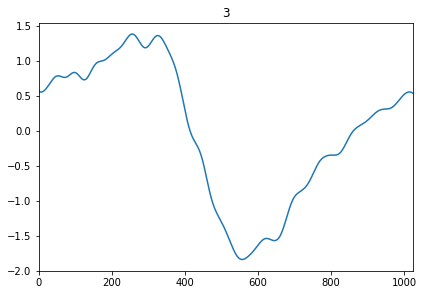

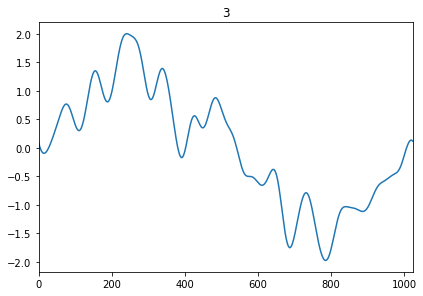

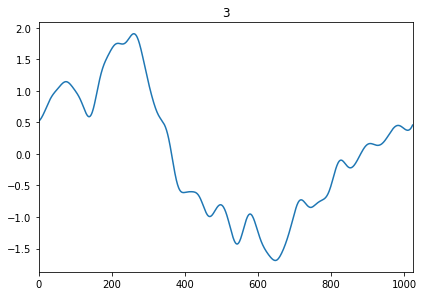

In [ ]:
dls.show_batch(max_n=3)

And there's our data! Now are we still on disk? *Yes*

In [ ]:
dls.dataset[0]

(memmap([[0.5373029 , 0.53110296, 0.52850294, ..., 0.52640295, 0.51950294,
          0.51140296]], dtype=float32), TensorCategory(2))

## Training our Model

THe particular model we're using is the [Inception Time](https://towardsdatascience.com/deep-learning-for-time-series-classification-inceptiontime-245703f422db) model. To do so we need the number of input classes and our number of variables:

In [ ]:
dls.c

3

In [ ]:
inp_vars = dls.dataset[0][0].shape[-2]

In [ ]:
inp_vars

1

In [ ]:
net = InceptionTime(inp_vars, dls.c)

In [ ]:
learn = Learner(dls, net, loss_func=CrossEntropyLossFlat(), metrics=accuracy, opt_func=ranger)

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.002511886414140463)

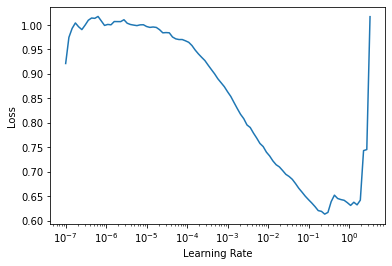

In [ ]:
learn.lr_find()

And now we can fit!

In [ ]:
learn.fit_flat_cos(10, 0.025)

epoch,train_loss,valid_loss,accuracy,time
0,0.539881,1.406547,0.641938,00:07
1,0.433147,0.335748,0.851506,00:07
2,0.373533,2.214681,0.559009,00:07
3,0.325850,0.599999,0.852477,00:07
4,0.295900,0.382158,0.837785,00:07
5,0.270379,0.178628,0.942205,00:07
6,0.252287,1.122112,0.765542,00:07
7,0.230175,0.151228,0.949247,00:07
8,0.200199,0.110600,0.972195,00:07
9,0.172292,0.106513,0.973045,00:07
